<a href="https://colab.research.google.com/github/Ahmed-M2020/zer0p_notebooks/blob/main/Copy_of_Experiment_14_10(feature_classifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from google.colab import drive
import os
import sys
import cv2
from PIL import Image
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import random
from sklearn.metrics import confusion_matrix
import tqdm
from torch.optim import lr_scheduler
from tqdm import tqdm
# Pytorch
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/filtered_data/final_filtered_df.csv'
df = pd.read_csv(file_path)
# df['Label'] = df['Label'].replace({'good': 1, 'bad': 0})
df.drop(columns=['Label'], inplace=True)
df.head()
# df.shape

Mounted at /content/drive


,Unnamed: 0,Surface Treatment [bbuchr; msahac],Acc,Resolution [dpi],Rounding [AV],Speed [mm/s],Tep [°C],Head Gap [mm],File,Feature,absolute_path
0,0,bbuchr,150.0,300.0,100.0,50.0,42.0,1,230523_Dataset01_Valeo_Nr01_0.png,dist.1,/content/drive/MyDrive/zerop/FTI Dataset 2023/...
1,1,bbuchr,150.0,300.0,100.0,50.0,42.0,1,230523_Dataset01_Valeo_Nr01_0.png,e.rought1,/content/drive/MyDrive/zerop/FTI Dataset 2023/...
2,2,bbuchr,150.0,300.0,100.0,50.0,42.0,1,230523_Dataset01_Valeo_Nr01_1.png,e.rought2,/content/drive/MyDrive/zerop/FTI Dataset 2023/...
3,3,bbuchr,150.0,300.0,100.0,50.0,42.0,1,230523_Dataset01_Valeo_Nr01_1.png,e.rought3,/content/drive/MyDrive/zerop/FTI Dataset 2023/...
4,4,bbuchr,150.0,300.0,100.0,50.0,42.0,1,230523_Dataset01_Valeo_Nr01_2.png,angle,/content/drive/MyDrive/zerop/FTI Dataset 2023/...


In [4]:
df = df.groupby('File').agg({
    'Feature': lambda x: ','.join(x),
    # 'Label': lambda x: ','.join(x),
    'absolute_path': 'first'
}).reset_index()

In [5]:
# Dictionary mapping feature names to indices
features_map = {
    'dist.1': 0, 'e.rought1': 1, 'e.rought2': 2, 'e.rought3': 3,
    'angle': 4, 'dist.6': 5, 'dots': 6, 'e.rought4': 7
}

# Create new columns for each feature initialized to 0
for feature in features_map.keys():
    df[feature] = 0

# Update the new feature columns to 1 if the feature appears in the 'Feature' column
for index, row in df.iterrows():
    feature_list = row['Feature'].split(',')  # Split the comma-separated features
    for feature in feature_list:
        if feature in features_map:
            df.at[index, feature] = 1

# Remove the 'Feature' column since we now have the individual features as columns
# df = df.drop(columns=['Feature'])

# Optionally reset the index and remove any duplicates
# df = df.drop_duplicates().reset_index(drop=True)

df.head()

,File,Feature,absolute_path,dist.1,e.rought1,e.rought2,e.rought3,angle,dist.6,dots,e.rought4
0,20240719_Dataset001_PETSample_01_0.png,dist.1,/content/drive/MyDrive/zerop_/FTI Dataset 2024...,1,0,0,0,0,0,0,0
1,20240719_Dataset001_PETSample_01_1.png,"e.rought2,e.rought3",/content/drive/MyDrive/zerop_/FTI Dataset 2024...,0,0,1,1,0,0,0,0
2,20240719_Dataset001_PETSample_01_2.png,"e.rought4,dots,dist.6,angle",/content/drive/MyDrive/zerop_/FTI Dataset 2024...,0,0,0,0,1,1,1,1
3,20240719_Dataset001_PETSample_02_0.png,"e.rought1,dist.1",/content/drive/MyDrive/zerop_/FTI Dataset 2024...,1,1,0,0,0,0,0,0
4,20240719_Dataset001_PETSample_02_1.png,"e.rought2,e.rought3",/content/drive/MyDrive/zerop_/FTI Dataset 2024...,0,0,1,1,0,0,0,0


In [6]:
df.shape

(607, 11)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, features, transform=None):
        self.image_paths = image_paths
        self.features = features
        self.transform = transform

    def __getitem__(self, idx):
        # Load image using OpenCV
        img_path = self.image_paths[idx]
        features = self.features[idx]

        # Read the image in grayscale mode (equivalent to 'L' in PIL)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Convert to PIL image to apply the same transform (if necessary)
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        # Convert features to tensor
        features = torch.tensor(features).float()

        return image, features

    def __len__(self):
        return len(self.image_paths)


In [47]:
torch.manual_seed(42)
np.random.seed(42)

# transform_train = transforms.Compose([
#     transforms.Resize((224, 224)), #(256, 256)
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=(0, 90)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5]),
# ])
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(0, 90)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [48]:
from sklearn.model_selection import train_test_split

# List of features (from the original feature_to_idx)
feature_columns = ['dist.1', 'e.rought1', 'e.rought2', 'e.rought3', 'angle', 'dist.6', 'dots', 'e.rought4']

def split_data(df, test_size=0.18, random_state=40):
    # Split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Prepare file paths
    X_train = train_df['absolute_path'].tolist()
    X_test = test_df['absolute_path'].tolist()

    # Select feature columns for training and testing (already in binary form)
    features_train = train_df[feature_columns].values  # Convert to numpy array
    features_test = test_df[feature_columns].values    # Convert to numpy array
    # y_train = train_df['Label'].values if 'Label' in train_df.columns else None
    # y_test = test_df['Label'].values if 'Label' in test_df.columns else None

    return X_train, X_test, features_train, features_test

In [49]:
X_train, X_test, features_train, features_test = split_data(df)

In [50]:
len(features_train), len(features_test), len(X_train), len(X_test)

(497, 110, 497, 110)

In [51]:
features_train[0], features_train[1], features_train[2]

(array([1, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]))

In [52]:
# y_train[0], y_train[1], y_train[2]

In [53]:
def calculate_feature_weights(features_train, device):
    # Count occurrences of each feature
    feature_counts = np.sum(features_train, axis=0)

    # Calculate weights (inverse of frequency)
    n_samples = features_train.shape[0]
    feature_frequencies = feature_counts / n_samples

    # Normalize weights
    epsilon = 1e-7
    inverse_frequencies = 1 / (feature_frequencies + epsilon)
    weights = inverse_frequencies / np.sum(inverse_frequencies)
    feature_weights = torch.FloatTensor(weights).to(device)

    return feature_weights

# Assuming you have your features_train and y_train from the split_data function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_weights = calculate_feature_weights(features_train, device)
# label_weights = calculate_feature_weights(y_train, device)

print(f"Feature Weights: {feature_weights}")
# print(f"Label Weights: {label_weights}")

Feature Weights: tensor([0.1184, 0.1292, 0.1192, 0.1209, 0.1292, 0.1354, 0.1184, 0.1292],
       device='cuda:0')


In [54]:
train_dataset = CustomDataset(X_train, features_train, transform=transform_train)
test_dataset = CustomDataset(X_test, features_test, transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=16,  num_workers=2, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [55]:
train_iterator = iter(train_loader)
data = next(train_iterator)
print(data[0].shape, data[1].shape)

torch.Size([16, 1, 224, 224]) torch.Size([16, 8])


In [33]:
class MultiFeatureModel(nn.Module):
    def __init__(self, num_features, feature_weights=None):
        super().__init__()
        self.base_model = models.mobilenet_v2().features
        self.base_model[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        last_channel = models.mobilenet_v2().last_channel
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=last_channel, out_features=1)  # Single output for each feature
            ) for _ in range(num_features)]
        )
        self.feature_weights = feature_weights

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        feature_outputs = [head(x) for head in self.heads]

        return torch.cat(feature_outputs, dim=1)

    def weighted_feature_cross_entropy(self, input, target):
        # , pos_weight=self.feature_weights
        return F.binary_cross_entropy_with_logits(input, target)

    # def get_loss(self, net_output, ground_truth):
    #     # Compute binary cross-entropy loss for each feature
    #     loss = F.binary_cross_entropy(net_output, ground_truth)
    #     return loss

In [18]:
class MultiHeadFeatureModel(nn.Module):
    def __init__(self, num_features, num_labels ,feature_weights=None, label_weights=None):
        super().__init__()
        self.base_model = models.mobilenet_v2().features
        self.base_model[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        last_channel = models.mobilenet_v2().last_channel

        # Pooling layer to reduce dimensions
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_weights = feature_weights
        self.label_weights = label_weights
        # Create separate heads for each feature
        self.heads_f = nn.ModuleList(
            [nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=last_channel, out_features=1)  # Single output for each feature
            ) for _ in range(num_features)]
        )
        self.heads_l = nn.ModuleList(
            [nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=last_channel, out_features=1)  # Single output for each feature
            ) for _ in range(num_labels)]
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)

        # Get outputs from each head
        feature_outputs = [head(x) for head in self.heads_f]
        label_outputs = [head(x) for head in self.heads_l]


        # Stack outputs to create a single tensor with shape (batch_size, num_features)
        return torch.cat(feature_outputs, dim=1) , torch.cat(label_outputs, dim=1)

    def weighted_feature_cross_entropy(self, input, target):
        return F.binary_cross_entropy_with_logits(input, target, pos_weight=self.feature_weights)
    def weighted_label_cross_entropy(self, input, target):
        return F.binary_cross_entropy_with_logits(input, target, pos_weight=self.label_weights)

In [56]:
class ResNetWithMultiHead(nn.Module):
    def __init__(self, num_feature_classes, feature_weights):
        super(ResNetWithMultiHead, self).__init__()

        # Load the pre-trained ResNet model
        self.backbone = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept 1-channel input if necessary
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=6, stride=2, padding=3, bias=True)

        # Extract the number of features from the fully connected layer
        num_ftrs = self.backbone.fc.in_features

        # Remove the original fully connected layer (fc)
        self.backbone.fc = nn.Identity()  # Acts as a pass-through layer

        # Shared features processing
        self.shared_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Create separate heads for each feature
        self.feature_heads = nn.ModuleList(
            [nn.Linear(128, 1) for _ in range(num_feature_classes)]  # One head for each feature
        )

        # Store the feature weights
        self.register_buffer('feature_weights', feature_weights)

    def forward(self, image):
        # Forward pass through the backbone
        x = self.backbone(image)

        # Process features
        shared_features = self.shared_fc(x)

        # Collect outputs from each feature head
        feature_outputs = [head(shared_features) for head in self.feature_heads]

        # Stack outputs to create a single tensor with shape (batch_size, num_feature_classes)
        return torch.cat(feature_outputs, dim=1)  # Shape will be (batch_size, num_feature_classes)

    def weighted_feature_cross_entropy(self, input, target):
        return F.binary_cross_entropy_with_logits(input, target) #, pos_weight=self.feature_weights


In [20]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.5 MB/s eta 0:00:00


In [21]:
from timm import create_model  # Import from timm for pretrained ViT

class ViTWithFeatureHead(nn.Module):
    def __init__(self, num_feature_classes, feature_weights):
        super(ViTWithFeatureHead, self).__init__()

        # Load the smaller pre-trained Vision Transformer (ViT)
        self.backbone = create_model('vit_small_patch16_224', pretrained=True)
        self.backbone.patch_embed.proj = nn.Conv2d(1, 384, kernel_size=16, stride=16)

        # Extract the number of features from the ViT model's classification head
        num_ftrs = self.backbone.head.in_features

        # Remove the original classification head (fc)
        self.backbone.head = nn.Identity()  # Acts as a pass-through layer

        for name, param in self.backbone.named_parameters():
            if "head" in name:  # Freeze the head (last layer)
                param.requires_grad = False

        # Shared features processing (simplified fully connected layer)
        self.shared_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Feature head
        self.feature_head = nn.Linear(256, num_feature_classes)

        # Store the feature weights for loss calculation
        self.register_buffer('feature_weights', feature_weights)

    def forward(self, image):
        # Forward pass through the backbone (ViT model)
        x = self.backbone(image)

        # Process features with simplified fully connected layer
        shared_features = self.shared_fc(x)

        # Output from feature head
        feature_output = self.feature_head(shared_features)

        return feature_output

    def weighted_feature_cross_entropy(self, input, target):
        return F.binary_cross_entropy_with_logits(input, target, pos_weight=self.feature_weights)


In [22]:
from timm import create_model

class ResNetWithFeatureHead(nn.Module):
    def __init__(self, num_feature_classes, feature_weights):
        super(ResNetWithFeatureHead, self).__init__()

        # Load the pre-trained SEResNet50 model
        self.backbone = create_model('seresnet50', pretrained=True)

        # Modify the first convolutional layer to accept 1-channel input
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Extract the number of features from the backbone's output
        self.backbone.fc = nn.Identity()  # Acts as a pass-through layer

        # Set num_ftrs to 2048 (the expected output size after the backbone)
        num_ftrs = 2048

        # Shared features processing
        self.shared_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),  # Set input size to 2048
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Feature head
        self.feature_head = nn.Linear(256, num_feature_classes)

        # Store the feature weights for loss calculation
        self.register_buffer('feature_weights', feature_weights)

    def forward(self, image):
        # Forward pass through the backbone (ResNet model)
        x = self.backbone(image)

        # Process features with shared fully connected layers
        shared_features = self.shared_fc(x)

        # Output from feature head
        feature_output = self.feature_head(shared_features)

        return feature_output

    def weighted_feature_cross_entropy(self, input, target):
        return nn.functional.binary_cross_entropy_with_logits(input, target, pos_weight=self.feature_weights)


In [57]:
# Initialize the model and move it to the device
# model = ResNetWithFeatureHead(num_feature_classes=8, feature_weights=feature_weights)
# model = ViTWithFeatureHead(num_feature_classes=8, feature_weights=feature_weights)
model = ResNetWithMultiHead(num_feature_classes=8, feature_weights=feature_weights)
# model = MultiHeadFeatureModel(num_features=8, num_labels=4, feature_weights=feature_weights, label_weights=label_weights)
# model = MultiFeatureModel(num_features=8, feature_weights=feature_weights)



model.to(device)
# for name, param in model.named_parameters():
#     if param.grad is not None:
#         print(f"{name} gradient: {param.grad.abs().mean().item()}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.3MB/s]


ResNetWithMultiHead(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [24]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 14.9 MB/s eta 0:00:00


In [58]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchmetrics.classification import MultilabelPrecision, MultilabelRecall, MultilabelF1Score
import numpy as np
import copy
from torch.cuda.amp import autocast, GradScaler  # For mixed precision

def model_train(model, train_loader, valid_loader, device, n_epochs, learning_rate, wd):

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=wd)

    # Reduce LR on plateau: monitor validation accuracy, and reduce if no improvement
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    scaler = torch.amp.GradScaler()  # For mixed precision training

    # Best validation accuracy tracking
    best_val_acc = -np.inf
    best_weights = None
    num_features = 8

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        feature_correct_train = 0

        # Training loop
        with tqdm(enumerate(train_loader), total=len(train_loader), unit="batch") as bar:
            bar.set_description(f"Epoch {epoch + 1}/{n_epochs}")
            for batch_idx, (imgs, feature_targets) in bar:
                imgs, feature_targets = imgs.to(device), feature_targets.to(device)
                optimizer.zero_grad()

                # Mixed precision forward pass
                with torch.amp.autocast(device_type=device.type):
                    feature_outputs = model(imgs)

                    # Compute the losses
                    feature_loss = model.weighted_feature_cross_entropy(feature_outputs, feature_targets)
                    loss = feature_loss

                # Backpropagation and optimization
                scaler.scale(loss).backward()
                # Log gradient norms before stepping
                # for name, param in model.named_parameters():
                #     if param.grad is not None:
                #         print(f"Layer: {name} | Gradient Norm: {param.grad.norm()}")

                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()

                # Accuracy calculation: apply sigmoid and threshold
                feature_outputs_probs = torch.sigmoid(feature_outputs)
                feature_preds = (feature_outputs_probs > 0.3).float()  # Apply threshold
                # print(f"Raw logits: {feature_outputs}")
                # print(f"Sigmoid outputs: {feature_outputs_probs}")
                # print(f"Predictions (after thresholding): {feature_preds}")
                # print(f"Targets: {feature_targets}")
                # Accuracy for feature head
                feature_correct_train += (feature_preds == feature_targets).float().sum().item()
                total_train += feature_targets.numel()

                # Training accuracy (correct predictions / total number of labels)
                train_acc_feature = feature_correct_train / total_train

                bar.set_postfix(
                    loss=running_loss / (batch_idx + 1),
                    feature_acc=train_acc_feature,
                    lr=scheduler.get_last_lr()[0]
                )

        # Validation phase with metrics tracking (precision, recall, F1)
        model.eval()
        precision = MultilabelPrecision(num_labels=num_features).to(device)
        recall = MultilabelRecall(num_labels=num_features).to(device)
        f1_score = MultilabelF1Score(num_labels=num_features).to(device)

        feature_correct_val = 0
        total_val = 0

        with torch.no_grad():
            for imgs, feature_targets in valid_loader:
                imgs, feature_targets = imgs.to(device), feature_targets.to(device)

                # Forward pass (no mixed precision for validation)
                feature_outputs = model(imgs)

                # Sigmoid activation for multi-label output
                feature_outputs_probs = torch.sigmoid(feature_outputs)
                feature_preds = (feature_outputs_probs > 0.3).float()  # Apply threshold

                # Track precision, recall, and F1
                precision.update(feature_preds, feature_targets)
                recall.update(feature_preds, feature_targets)
                f1_score.update(feature_preds, feature_targets)

                # Accuracy for feature head
                feature_correct_val += (feature_preds == feature_targets).float().sum().item()
                total_val += feature_targets.numel()

        val_acc_feature = feature_correct_val / total_val
        precision_score = precision.compute().mean().item()
        recall_score = recall.compute().mean().item()
        f1_score_value = f1_score.compute().mean().item()

        print(f"Epoch {epoch + 1} Validation Accuracy - Feature: {val_acc_feature * 100:.2f}%")
        print(f"Precision: {precision_score:.4f}, Recall: {recall_score:.4f}, F1: {f1_score_value:.4f}")

        # Save the best model weights based on validation accuracy
        if val_acc_feature > best_val_acc:
            best_val_acc = val_acc_feature
            best_weights = copy.deepcopy(model.state_dict())
            print(f"Best validation accuracy ({best_val_acc * 100:.2f}%)")

        # Scheduler step: Reduce learning rate if validation accuracy plateaus
        scheduler.step(val_acc_feature)

    # Return the best validation accuracy and the model's best weights
    return best_val_acc, best_weights

In [ ]:
best_acc, best_weights = model_train(model, train_loader, valid_loader, device, n_epochs=50, learning_rate=1e-3, wd= 1e-6)
if best_acc > 0.895:
    accuracy_str = f'{best_acc * 100:.2f}'.replace('.', '_')
    save_path = f'/content/drive/MyDrive/Results/saved_models/resnet18/filtered/best_model_{accuracy_str}.pth'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(best_weights , save_path)
    # model.load_state_dict(best_weights)
    print(f"Saved the Best Accuracy: {best_acc * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|██████████| 32/32 [00:35<00:00,  1.11s/batch, feature_acc=0.705, loss=0.457, lr=0.001]


Epoch 1 Validation Accuracy - Feature: 68.52%
Precision: 0.6994, Recall: 0.3742, F1: 0.3101
Best validation accuracy (68.52%)


Epoch 2/50: 100%|██████████| 32/32 [00:40<00:00,  1.25s/batch, feature_acc=0.884, loss=0.302, lr=0.001]


Epoch 2 Validation Accuracy - Feature: 69.66%
Precision: 0.6643, Recall: 0.4565, F1: 0.4254
Best validation accuracy (69.66%)


Epoch 3/50: 100%|██████████| 32/32 [00:35<00:00,  1.11s/batch, feature_acc=0.904, loss=0.264, lr=0.001]


Epoch 3 Validation Accuracy - Feature: 85.57%
Precision: 0.7216, Recall: 0.8194, F1: 0.7546
Best validation accuracy (85.57%)


Epoch 4/50: 100%|██████████| 32/32 [00:35<00:00,  1.10s/batch, feature_acc=0.919, loss=0.255, lr=0.001]


Epoch 4 Validation Accuracy - Feature: 75.68%
Precision: 0.6517, Recall: 0.8138, F1: 0.6556


Epoch 5/50: 100%|██████████| 32/32 [00:39<00:00,  1.22s/batch, feature_acc=0.92, loss=0.232, lr=0.001]


Epoch 5 Validation Accuracy - Feature: 87.95%
Precision: 0.7550, Recall: 0.8727, F1: 0.8004
Best validation accuracy (87.95%)


Epoch 6/50: 100%|██████████| 32/32 [00:35<00:00,  1.11s/batch, feature_acc=0.924, loss=0.21, lr=0.001]


Epoch 6 Validation Accuracy - Feature: 92.95%
Precision: 0.8015, Recall: 0.9955, F1: 0.8859
Best validation accuracy (92.95%)


Epoch 7/50: 100%|██████████| 32/32 [00:39<00:00,  1.24s/batch, feature_acc=0.926, loss=0.229, lr=0.001]


Epoch 7 Validation Accuracy - Feature: 93.41%
Precision: 0.8087, Recall: 1.0000, F1: 0.8927
Best validation accuracy (93.41%)


Epoch 8/50: 100%|██████████| 32/32 [00:35<00:00,  1.12s/batch, feature_acc=0.929, loss=0.25, lr=0.001]


Epoch 8 Validation Accuracy - Feature: 92.50%
Precision: 0.7930, Recall: 0.9832, F1: 0.8769


Epoch 9/50: 100%|██████████| 32/32 [00:37<00:00,  1.16s/batch, feature_acc=0.925, loss=0.24, lr=0.001]


Epoch 9 Validation Accuracy - Feature: 90.57%
Precision: 0.7637, Recall: 0.9642, F1: 0.8486


Epoch 10/50: 100%|██████████| 32/32 [00:35<00:00,  1.11s/batch, feature_acc=0.907, loss=0.257, lr=0.001]


Epoch 10 Validation Accuracy - Feature: 92.84%
Precision: 0.8012, Recall: 0.9914, F1: 0.8838


Epoch 11/50: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, feature_acc=0.924, loss=0.218, lr=0.001]


Epoch 11 Validation Accuracy - Feature: 92.27%
Precision: 0.7896, Recall: 0.9921, F1: 0.8767


Epoch 12/50:  78%|███████▊  | 25/32 [00:30<00:06,  1.01batch/s, feature_acc=0.933, loss=0.188, lr=0.0001]

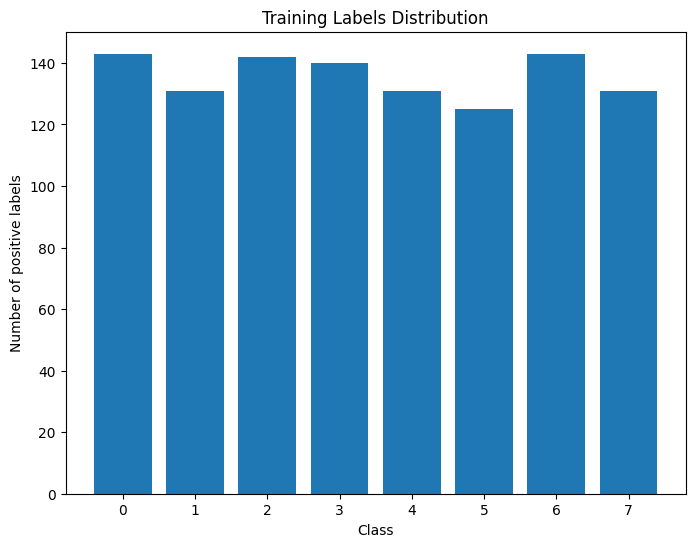

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a tensor to hold the sum of labels for each class
num_classes = train_loader.dataset[0][1].shape[0]  # assuming dataset returns (image, labels)
label_counts = torch.zeros(num_classes)

# Iterate over the dataset to count labels
for _, labels in train_loader:
    label_counts += labels.sum(dim=0)  # Summing positive labels for each class

# Convert to numpy for plotting
label_counts = label_counts.cpu().numpy()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(np.arange(num_classes), label_counts)
plt.xlabel('Class')
plt.ylabel('Number of positive labels')
plt.title('Training Labels Distribution')
plt.show()